# Validation of dynamic solver - non-zero reference cases

These studies consider aerofoils at non-zero angles of attack. Unless otherwise specified, a flat plate is always considered in these tests. Studies will consider plunge motion and gust response.

#### Important:
   This version of the linear solver is based on a linearisation of both state and output equations. 
   Being $\Gamma_0$ the circulation at the reference (linearisation) point, and $\Delta\Gamma$ the incremental circulation, the total circulation is computed as:
$$\Gamma=\Gamma_0+\Delta\Gamma$$
Similarly, the total aerodynamic force is obtained as:
$$
F = F_0 + \Delta F
$$

In summary, the discrete-time state-space formulation used is:
$$
\Delta x^{n+1}=A \Delta x^n + B \Delta u^{n+1} \\
\Delta y^{n+1} = C \Delta x^{n+1} + D \Delta u^{n+1}
$$
where $x$ and $u$ are system state and input.

In [2]:
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import uvlm2d_sta
import lin_uvlm2d_dyn
import pp_uvlm2d as pp
import analytical as an
import geo, set_dyn, set_gust

from IPython.utils import io

## Aerofoil in plunge motion

In this test case, the aerofoil has a nonzero zero angle of attack and an harmonic plunge motion is enforce. Lift is verified against Theodorsen solution, while the induced drag is checked against Garrik solution. Below, tests are performed at both low and high frequency.

### Low reduced frequency

In [21]:
### random geometry
c=3.
b=0.5*c
ktarget=0.1
H=0.01*b
f0=2.#Hz
w0=2.*np.pi*f0 #rad/s
uinf=b*w0/ktarget
alpha0=1.0*np.pi/180.
# Numerical solution
Ncycles=5.
WakeFact=30
T=2.*np.pi*Ncycles/w0
M=20

### reference static solution
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                       Uinf=np.array([uinf,0.]),alpha=alpha0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

### Linearised solution
Slin=lin_uvlm2d_dyn.solver(S0,T)
Slin=set_dyn.plunge(Slin,f0,H)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()
print('... done!')

### total force
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0
THFcirc=THFtot-Slin.THFaero_m

### post-process
hc_num=(Slin.THZeta[:,0,1]-H)/S0.chord
aeffv_num=-np.arctan(Slin.THdZetadt[:,0,1]/S0.Uinf[0])
THCF=THFtot/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THFcirc/S0.qinf/S0.chord

### Analytical solution
hv_an=-H*np.cos(w0*Slin.time)
hc_an=hv_an/S0.chord
dhv=w0*H*np.sin(w0*Slin.time)
aeffv_an=np.arctan(-dhv/S0.Uabs)
# drag - Garrik
Cdv=an.garrick_drag_plunge(w0,H,S0.chord,S0.rho,uinf,Slin.time)
# lift - Theodorsen
Ltot_an,Lcirc_an,Lmass_an=an.theo_lift(
                              w0,0,H,S0.chord,S0.rho,S0.Uinf[0],0.0)
# static lift
L0=2.0*np.pi*alpha0*S0.chord*S0.qinf

ph_tot=np.angle(Ltot_an)
CLtot_an=(L0+np.abs(Ltot_an)*np.cos(w0*Slin.time+ph_tot))\
                                                /(S0.chord*S0.qinf)


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


... done!


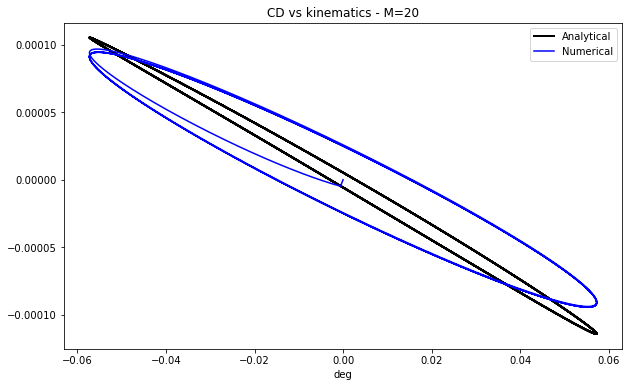

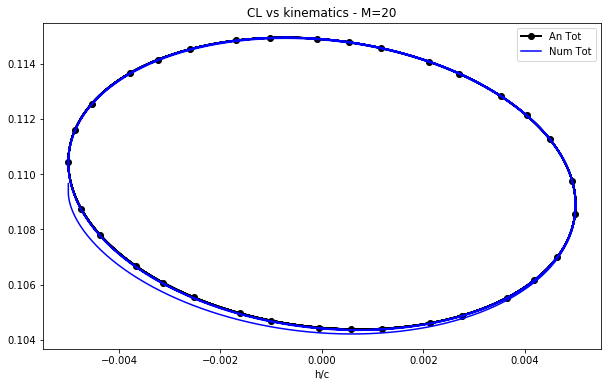

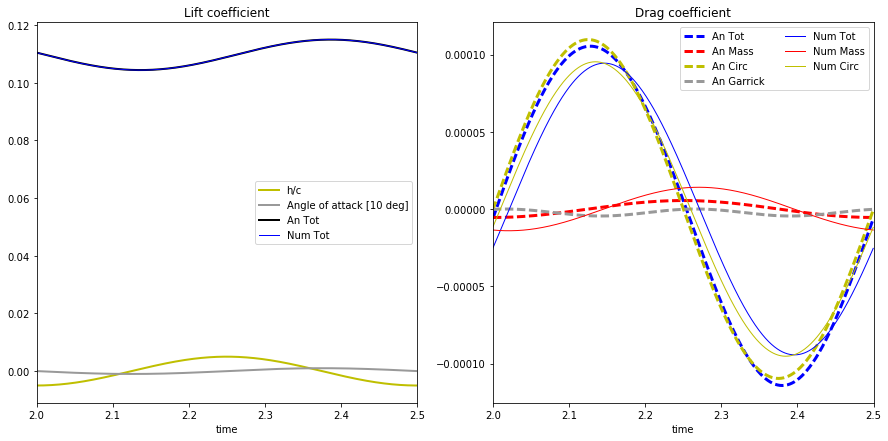

In [22]:
### add steady lift contribution to drag
CL0=2.*np.pi*alpha0#*S0.qinf*S0.chord
Cdv_circ=-CL0*aeffv_an
ddhv=w0**2 *H*np.cos(w0*Slin.time)
Cdv_mass=-1.225*np.pi*b**2*ddhv*alpha0 /S0.qinf/S0.chord


### Phase plots
fig = plt.figure('Induced drag in plunge motion -'
                                  ' Phase vs kinematics - exact derivative',(10,6))
ax=fig.add_subplot(111)
ax.plot(180./np.pi*aeffv_an,Cdv+Cdv_circ+Cdv_mass,'k',lw=2,label=r'Analytical')
ax.plot(180./np.pi*aeffv_num,THCF[:,0],'b',label=r'Numerical')
ax.set_xlabel('deg')
ax.set_title('CD vs kinematics - M=%s'%M)
ax.legend()
plt.show()

fig = plt.figure('Lift in plunge motion - '
                                   'Phase vs kinematics',(10,6))
ax=fig.add_subplot(111)
# analytical
ax.plot(hc_an,CLtot_an,'k',lw=2,marker='o',markevery=(.3),
                                                label=r'An Tot')
# numerical
ax.plot(hc_num,THCF[:,1],'b',label=r'Num Tot')
ax.set_xlabel('h/c')
ax.set_title('CL vs kinematics - M=%s'%M)
ax.legend()

### Time histories
fig = plt.figure('Time histories',(15,7))
ax=fig.add_subplot(121)
ax.plot(Slin.time,hc_num,'y',lw=2,label='h/c')
ax.plot(Slin.time,aeffv_num,'0.6',lw=2,label='Angle of attack [10 deg]')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label='An Tot')
ax.plot(Slin.time,THCF[:,1],'b',lw=1,label='Num Tot')
ax.set_xlabel('time')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_title('Lift coefficient')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Slin.time, Cdv+Cdv_circ+Cdv_mass,'b',ls='--',lw=3,label='An Tot')
ax.plot(Slin.time, Cdv_mass,'r',ls='--',lw=3,label='An Mass')
ax.plot(Slin.time, Cdv_circ,'y',ls='--',lw=3,label='An Circ')
ax.plot(Slin.time, Cdv,'0.6',ls='--',lw=3,label='An Garrick')
ax.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax.plot(Slin.time, THCFmass[:,0],'r',lw=1,label='Num Mass')
ax.plot(Slin.time, THCFcirc[:,0],'y',lw=1,label='Num Circ')
ax.set_xlim((1.-1./Ncycles)*T, T)
ax.set_xlabel('time')
ax.set_title('Drag coefficient')
ax.legend(ncol=2)

plt.show() 

The lift predicted analytically is the sum of the steady lift contribution at the angle of attack $\alpha_0$ and the unsteady oscillatory contribution due to the plunge motion. This compares perfectly with the lift estimated numerically.

As opposed to the case in which the plate has a zero angle of attack, a non-zero drag is here predicted by the numerical model. This is much larger than the Garrick term, which arises from second order effects. As shown in the figure, this contribution to the drag is linked to both the circulatory and added mass terms. These are explained as follows:
- The added mass force is perpendicular to the panels normal, which are not perpendicular to the horizontal axis. Therefore, this term will contribute to the drag only when the plate is at non-zero incidence, regardless to whether a linearised or exact solution is sought. This term is small as compared to the circulatory one due to the slow (k=0.1) dynamics.

- In steady analysis, it has been seen that the circulatory aerodynamic force can produce an horizontal component of the force if the linearisation is about a point ($\alpha_{eff}$) in which:
    - either $F_x \neq 0$
    - or $\frac{d F_x}{d \alpha_{eff}} \neq 0$
This term is first order, and can be captured by the linear model.

In summary:
- when an exact solution is sought:
    - the circulatory lift produces induced drag always. If the plate is at zero incidence, only the Garrick term, which is second order, is present. When the plate is at an angle of attack, instead, also the circulatory lift will contribute. This term is first order.
    - the added mass produces drag only if the plate has a non-zero incidence
- if a linearised solution is sought:
    - the second order Garrick term will never be captured.
    - the first order circulatory contribution will be seen if the plate has a non-zero angle of attack.
    - the added mass will contribute to drag if the flat has a non-zero angle of attack.

An accurate analytical formulation to verify the induced drag computed by the linearised model is not available. This, however, has been approximated as follows:
- the circulatory contribution is estimated tilting the steady lift ($C_{L_0}$), along the direction of the instantaneous flow speed ($\alpha_{eff}=-\frac{\dot{h}}{U_\infty}$) and projecting it along the horizontal axis. Note that this approximation does not account for the $\Delta C_L$ produced by the small variations of effective angle of attack (which is, however, negligible as compared to $C_{L_0}$ in this study) and delay caused by the wake (which is clearly observed in the $C_D$ phase diagram). Nonetheless, the trend obtained is very close to the circulatory lift predicted numerically.
- the added mass force, negligible in this low reduced frequency case, has been estimated using the mass coefficient, $m=\frac{\pi}{2} \rho b^2$, provided by the potential flow theory and projecting the force obtained along the horizontal axis:
$$
C_{D_m} = - m \ddot{h} \alpha_{eff} \ \ \ \mbox{where} \ \ \ m=\frac{\pi}{2} \rho b^2
$$

## Sinusoidal gust
Finally, we consider the response to a sinusoidal gust (Sears' solution) at low/high values of the reduced frequency 
$$
k_g=\frac{\pi c}{\lambda_g}
$$
where $\lambda_g$ is the gust length. A medium reduced frequency, $k_g=0.5$, has been chosen for this study.

In [10]:
# random geometry
c=3.
b=0.5*c

# gust profile
w0=0.05
uinf=2.0
alpha0=1.0*np.pi/180.
kg=0.5
L=np.pi*c/kg
print('Reduced frequency: %.2f' %kg)
print('Gust length %.2f chords'%(L/c))

# discretisation
WakeFact=20
Ncycles=22 # number of "cycles"
Mfact=10
if c>L: M=np.ceil(4*Mfact*c/L)
else: M=Mfact*4
print('aerofoil panels M=%d' %M)
print('Panels per wavelength %d'%int(M*L/c))

# Reference state
S0=uvlm2d_sta.solver(M=M,Mw=M*WakeFact,b=b,
                           Uinf=np.array([uinf,0.]),alpha=alpha0,rho=1.225)
S0.build_flat_plate()
S0.solve_static_Gamma2d()
Ftot0=np.sum(S0.Faero,0)

# Linearised model
Slin=lin_uvlm2d_dyn.solver(S0,T=Ncycles*L/uinf)
Slin=set_gust.sin(Slin,w0,L,ImpStart=False)
Slin.eps_Hall=0.003
with io.capture_output() as captured:
    Slin.solve_dyn_Gamma2d()
print('... done!')
THFtot=0.0*Slin.THFaero
for tt in range(Slin.NT):
    THFtot[tt,:]=Slin.THFaero[tt,:]+Ftot0    
THCF=THFtot/S0.qinf/S0.chord
THCFmass=Slin.THFaero_m/S0.qinf/S0.chord
THCFcirc=THCF-THCFmass

# Analytical solution
CLv=an.sears_lift_sin_gust(w0,L,uinf,c,Slin.time)
CL0=2.0*np.pi*alpha0
CLtot_an=CL0+CLv

Reduced frequency: 0.50
Gust length 6.28 chords
aerofoil panels M=40
Panels per wavelength 251


../save.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if value != None:


... done!


Error CL max: 0.007
Error Time maximum: 0.000


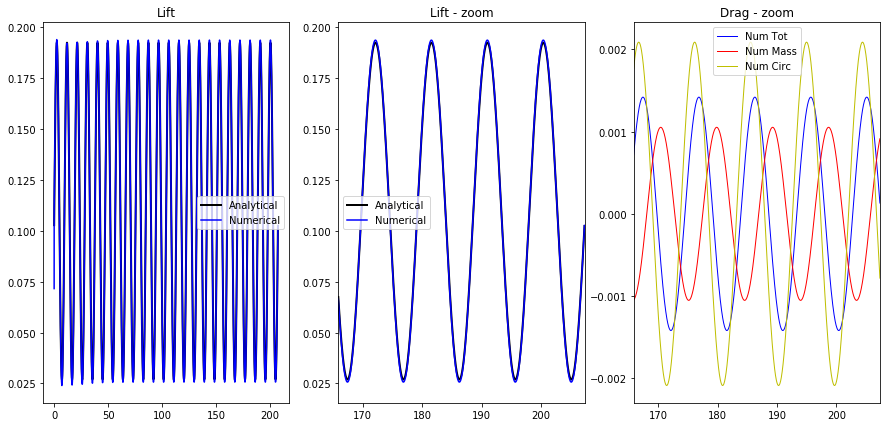

In [12]:
# post-process
ttvec=Slin.time>float(Ncycles-1)/Ncycles*Slin.T
# numerical solution
ttmax=np.argmax(THCF[ttvec,1])
Tmax=Slin.time[ttvec][ttmax]
CLmax=THCF[ttvec,1][ttmax]
# an. sol
ttmax=np.argmax(CLv[ttvec])
Tmax_an=Slin.time[ttvec][ttmax]
CLmax_an=CLtot_an[ttvec][ttmax] 

ErCL= np.abs(CLmax/CLmax_an-1.0) 
Period=L/uinf
ErTmax=np.abs((Tmax-Tmax_an)/Period)
print('Error CL max: %.3f' %ErCL)
print('Error Time maximum: %.3f' %ErTmax)


fig = plt.figure('Aerodynamic force coefficients',(15,7))
ax=fig.add_subplot(131)
ax.set_title(r'Lift')
ax.plot(Slin.time,CLtot_an,'k',lw=2,label=r"Analytical")
ax.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax.legend()

ax2=fig.add_subplot(132)
ax2.set_title(r'Lift - zoom')
ax2.plot(Slin.time,CLtot_an,'k',lw=2,label=r"Analytical")
ax2.plot(Slin.time,THCF[:,1],'b',label=r'Numerical')
ax2.set_xlim(0.8*Slin.T,Slin.T)
ax2.legend()

ax3=fig.add_subplot(133)
ax3.set_title(r'Drag - zoom')
ax3.plot(Slin.time, THCF[:,0],'b',lw=1,label='Num Tot')
ax3.plot(Slin.time, THCFmass[:,0],'r',lw=1,label='Num Mass')
ax3.plot(Slin.time, THCFcirc[:,0],'y',lw=1,label='Num Circ')
ax3.set_xlim(0.8*Slin.T,Slin.T)
ax3.legend()

plt.show()

Even in this case the agreement is satisfactory, with error in maximum amplitude of the lift coefficient below 1% and the steady lift contribution correctly accounted for. While and analytical reference for the drag is not available, we can see that, as in the plunge motion case, the non-zero incidence of the aerofoil allows the model to predict also the first order circulatory contribution to drag - other than the added mass effect.